# Setup

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ESA-Datalabs/XAMI-model/blob/main/dataset_and_model.ipynb)

In [1]:
import sys
import os

if 'google.colab' in sys.modules:
    !pip install -q condacolab
    import condacolab
    condacolab.install()

In [2]:
!git clone https://github.com/ESA-Datalabs/XAMI-model.git

Cloning into 'XAMI-model'...
remote: Enumerating objects: 1060, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 1060 (delta 91), reused 102 (delta 47), pack-reused 901
Receiving objects: 100% (1060/1060), 101.70 MiB | 21.86 MiB/s, done.
Resolving deltas: 100% (584/584), done.


In [3]:
os.chdir("XAMI-model")

In [4]:
!conda env update -n base -f environment.yaml
!pip install -e .

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
 - local
Platform: linux-64

## Download dataset

In [3]:
!git clone https://github.com/ESA-Datalabs/XAMI-dataset.git
!pip install -e XAMI-dataset/

Cloning into 'XAMI-dataset'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 232 (delta 110), reused 171 (delta 52), pack-reused 0
Receiving objects: 100% (232/232), 2.30 MiB | 5.32 MiB/s, done.
Resolving deltas: 100% (110/110), done.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///workspace/raid/OM_DeepLearning/XAMI-model/XAMI-dataset
  Preparing metadata (setup.py) ... done
  Running setup.py develop for xami-dataset


In [4]:
from xami_dataset.loader import XAMIDataset

# Download the dataset
xami_dataset = XAMIDataset(
    repo_id="iulia-elisa/XAMI-dataset",
    dataset_name="xami_dataset",
    dest_dir='./data_2')

ModuleNotFoundError: No module named 'xami_dataset'

In [10]:
from xami_dataset.xami_utils import coco_to_yolo_converter

convert = True # if True, converts coco dataset to yolo format

if convert: 
    coco_to_yolo_converter.convert_coco_to_yolo(
    dir_absolute_path=os.getcwd(),
    dataset_path='./data_2/xami_dataset/',
    yolo_dataset_path=os.path.join(os.getcwd(), 'data_2/xami_dataset_YOLO')
)

Processed 790 files.
Processed 264 files.
YAML file /workspace/raid/OM_DeepLearning/XAMI-model/data_2/xami_dataset_YOLO/data.yaml created and saved.


## Download model weights

In [ ]:
from huggingface_hub import hf_hub_download

dest_dir = './train/weights/'
checkpoints = [
    'yolo_weights/yolov8_detect_300e_best.pt', 
    'yolo_weights/yolov8_detect_300e_last.pt', \
    'sam_weights/sam_0_best.pth', 
    'yolo_sam_final.pth']

# download checkpoints from HuggingFace
for checkpoint in checkpoints:
    hf_hub_download(
    			repo_id="iulia-elisa/XAMI-model",
    			repo_type='model',
    			filename=checkpoint,
    			local_dir=dest_dir
    		)
print(f'Checkpoints saved in {dest_dir}')

# Inference

In [13]:
from xami_model.inference.xami_inference import InferXami

detr_checkpoint = './train/rt-detr-iter0/rtdetr-l4/weights/last.pt'
# detr_checkpoint = './train/yolov8-segm-0/yolov8n-seg6/weights/best.pt'
sam_checkpoint = './train/output_sam_8/sam_0_2024-06-05 13:08:02.871454_best.pth'

# the SAM checkpoint and model_type (vit_h, vit_t, etc.) must be compatible
detr_sam_pipeline = InferXami(
    device='cuda:0',
    detr_checkpoint=detr_checkpoint,
    sam_checkpoint=sam_checkpoint,
    model_type='vit_t',
    use_detr_masks=False)

ModuleNotFoundError: No module named 'supervision'

Number of object detected: 19
   central-ring
   read-out-streak
   smoke-ring
   star-loop


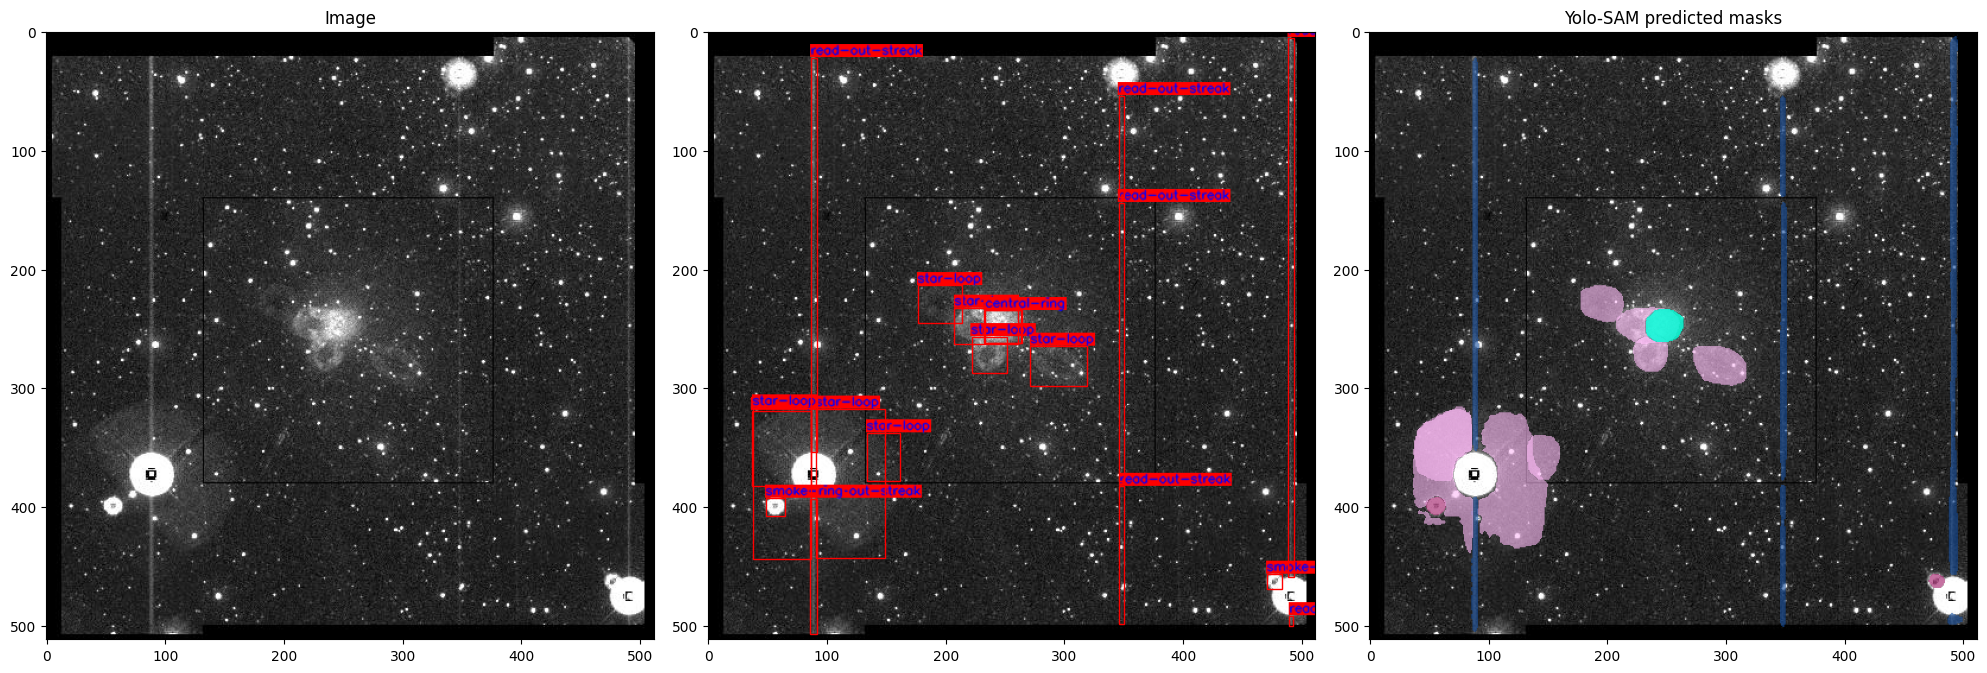

In [4]:
# masks = detr_sam_pipeline.run_predict('../XAMI-dataset/xami_dataset/valid/S0743200101_V_png.rf.dba4ec263252737ec92121f599a4ca8b.jpg', show_masks=True)
# masks = detr_sam_pipeline.run_predict('./example_images/S0743200101_V.jpg', show_masks=True) 
masks = detr_sam_pipeline.run_predict('../XAMI-dataset/data/xami_dataset/valid/S0604980201_L_png.rf.50a2ef55be16b3e7f688869309e22052.jpg', show_masks=True)

In [ ]:
masks = detr_sam_pipeline.run_predict('./example_images/S0893811101_M.png', show_masks=True)

# Combined training example

In [ ]:
# Restarting and running from this point would be better
# Because after inference, there is a model already on GPU => OOM

import os
os.chdir("XAMI-model")

In [ ]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
import cv2
import torch
import os
import numpy as np
import random
import json
import sys
from datetime import datetime

# os.environ['CUDA_VISIBLE_DEVICES'] = "0, 1, 2, 3" # replace with the GPU IDs that are available

# to help with reproducibility
seed=0
import torch.backends.cudnn as cudnn
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.benchmark, cudnn.deterministic = False, True

np.set_printoptions(precision=9)

sys.path.append('../') # workaround for lack of relative import in notebooks
from sam_predictor import predictor_utils, astro_sam #, residualAttentionBlock
from losses import metrics_utils
from dataset import dataset_utils

In [ ]:
kfold_iter=0

device_id=0
batch_size=4
lr=3e-5
wd=0.0005
wandb_track=False
torch.cuda.set_device(device_id)
datetime_now = datetime.now()

if wandb_track:
    # !pip install wandb
    # !wandb login
    import wandb
    wandb.login()
    run = wandb.init(project="yolo-sam", name=f"yolo-sam {datetime_now}")

In [ ]:
yolo_dataset_path = './data/xami_dataset_YOLO/' # replace with the path to the YOLO dataset

import yaml

with open(yolo_dataset_path+f"data.yaml", 'r') as stream:
    yam_data = yaml.safe_load(stream) # dictionary with keys 'names', 'nc', 'train', 'val'

classes = {i:name for i, name in enumerate(yam_data['names'])}
train_path = yam_data['train']
val_path = yam_data['val']
print(classes)

coco_data_path = f'./data/xami_dataset/'
annotations_file = '_annotations.coco.json'

with open(coco_data_path+'train/'+annotations_file, 'r') as f1, open(coco_data_path+'valid/'+annotations_file, 'r') as f2:
    train_coco_data = json.load(f1)
    valid_coco_data = json.load(f2)

train_dir = yolo_dataset_path+f'train/images/'
valid_dir = yolo_dataset_path+f'valid/images/'

train_image_files = os.listdir(train_dir)
valid_image_files = os.listdir(valid_dir)

In [ ]:
import sys
sys.path.append(os.path.join(os.getcwd(), 'mobile_sam'))
from mobile_sam import sam_model_registry, SamPredictor

device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"
mobile_sam_checkpoint = './train/weights/sam_weights/sam_0_best.pth'

yolov8_pretrained_model = YOLO(f'./train/weights/yolo_weights/best.pt');
yolov8_pretrained_model.to(f'cuda:{device_id}');
mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device)
predictor = SamPredictor(mobile_sam_model)

In [ ]:
astrosam_model = astro_sam.AstroSAM(mobile_sam_model, device, predictor)
# astrosam_model = astro_sam.AstroSAM(
#     mobile_sam_model,
#     device,
#     predictor,
#     use_yolo_masks=True,
#     wt_threshold=0.6,
#     wt_classes_ids = [1.0, 4.0])

In [ ]:
device

In [ ]:
for name, param in mobile_sam_model.named_parameters():
    if 'mask_decoder' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

print(f"🚀 The model has {sum(p.numel() for p in astrosam_model.model.parameters() if p.requires_grad)} trainable parameters.")
# print(f"🚀 The residual attention block has {sum(p.numel() for p in astrosam_model.residualAttentionBlock.parameters() if p.requires_grad)} trainable parameters.\n")

# predictor_utils.check_requires_grad(astrosam_model.model)
# predictor_utils.check_requires_grad(astrosam_model.residualAttentionBlock)

In [ ]:
import time
import torch.nn.functional as F
import tqdm
from tqdm import tqdm

train_num_batches = len(train_image_files) // batch_size
valid_num_batches = len(valid_image_files) // batch_size
parameters_to_optimize = [param for param in mobile_sam_model.mask_decoder.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(parameters_to_optimize, lr=lr, weight_decay=wd) if len(parameters_to_optimize) > 0 else None

In [ ]:
from torch import tensor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint

metric_thresholds = [[0.5], [0.75], [0.5, 0.9]]

In [ ]:
from collections import defaultdict

best_valid_loss = float('inf')
num_epochs = 1
n_epochs_stop = num_epochs // 10 + 5
all_metrics = defaultdict(dict)
compute_metrics = True

In [ ]:
# Intro
predictor_utils.print_training_intro(
    train_image_files, valid_image_files, device, metric_thresholds, num_epochs,
    batch_size, lr, wd, wandb_track, mobile_sam_model, 'AdamW')

# Training loop
for epoch in range(num_epochs):

    # Train
    astrosam_model.model.train()

    # astrosam_model.residualAttentionBlock.train()
    train_results = astrosam_model.run_yolo_sam_epoch(
        yolov8_pretrained_model,
        phase='train',
        batch_size=batch_size,
        image_files=train_image_files,
        images_dir=train_dir,
        num_batches=train_num_batches,
        optimizer=optimizer)

    epoch_sam_loss_train, train_preds, train_gts = train_results[:3]
    train_gt_classes, train_pred_classes, train_all_iou_scores, train_mask_areas, _ = train_results[3:]

    # Validate
    astrosam_model.model.eval()
    # astrosam_model.residualAttentionBlock.eval()

    with torch.no_grad():
        valid_results = astrosam_model.run_yolo_sam_epoch(
            yolov8_pretrained_model,
            phase='val',
            batch_size=batch_size,
            image_files=valid_image_files,
            images_dir=valid_dir,
            num_batches=valid_num_batches,
            optimizer=None)

    epoch_sam_loss_val, valid_preds, valid_gts = valid_results[:3]
    valid_gt_classes, valid_pred_classes, valid_all_iou_scores, valid_mask_areas, pred_images = valid_results[3:]

    # Early stopping
    if epoch_sam_loss_val < best_valid_loss:
        best_valid_loss = epoch_sam_loss_val
        best_model = astrosam_model.model
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print("Early stopping initiated.")
            early_stop = True
            break

    # Metrics
    if compute_metrics:
        for threshold in tqdm(metric_thresholds, desc="(Metrics) Processing thresholds", bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
            metric = MeanAveragePrecision(
            iou_type = "segm",
            iou_thresholds = threshold,
            max_detection_thresholds=[1, 10, 100],
            class_metrics=True,
            extended_summary=False)

            train_metrics = metrics_utils.mAP_metrics(metric,
            train_preds,
            train_gts,
            train_gt_classes,
            train_pred_classes,
            train_all_iou_scores,
            train_mask_areas,
            show_metrics=False)

            valid_metrics = metrics_utils.mAP_metrics(metric,
                    valid_preds,
                    valid_gts,
                    valid_gt_classes,
                    valid_pred_classes,
                    valid_all_iou_scores,
                    valid_mask_areas,
                    show_metrics=False)

            all_metrics[tuple(threshold)] = {'train': train_metrics, 'valid': valid_metrics}

        # Prints
        if not wandb_track:
            wandb = None
        predictor_utils.prints_and_wandb(
            epoch,
            epoch_sam_loss_train,
            epoch_sam_loss_val,
            all_metrics,
            metric_thresholds,
            wandb)

    # Checkpoint save
    torch.save(best_model.state_dict(), f'yolo_sam_{epoch}.pth')

torch.save(best_model.state_dict(), f'yolo_sam_final.pth')

# Finish wandb run
if wandb_track:
    run.finish()

def convert_tensors(data):
    if isinstance(data, dict):
        return {key: convert_tensors(value) for key, value in data.items()}
    elif isinstance(data, torch.Tensor):
        return data.tolist() if data.ndim > 0 else data.item()
    else:
        return data

if compute_metrics:
    metrics_dict = defaultdict(dict)
    metrics_dict[f'{metric_thresholds[0][0]}'] = convert_tensors(all_metrics[tuple(metric_thresholds[0])])
    metrics_dict[f'{metric_thresholds[1][0]}'] = convert_tensors(all_metrics[tuple(metric_thresholds[1])])
    metrics_dict[f'{metric_thresholds[2][0]}-{metric_thresholds[2][1]}'] = convert_tensors(all_metrics[tuple(metric_thresholds[2])])
    metrics_dict['best_epoch'] = best_epoch

    with open(f'metrics_{datetime_now}.json', 'w') as json_file:
        json.dump(metrics_dict, json_file, indent=4)

In [ ]:
metrics_dict